In [19]:

import cv2
import numpy as np
from tqdm import tqdm
from statistics import mean
from joblib import dump, load
from tensorflow import keras
from skimage.feature import hog
from skimage import data, exposure
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

In [20]:

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
assert y_train.shape == (50000,)
assert y_test.shape == (10000,)

In [21]:
def preprocess(xs):
    hog_imgs = []
    for x in tqdm(xs):
        gray = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY) / 255
        fd = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                    	cells_per_block=(2, 2))
        hog_imgs.append(fd)
    return np.array(hog_imgs)

In [22]:

x_train = preprocess(x_train)
#x_test = preprocess(x_test)

100%|██████████| 50000/50000 [00:34<00:00, 1455.34it/s]


In [23]:
print(x_train.shape)
print(preprocess(x_test).shape)

(50000, 324)


100%|██████████| 10000/10000 [00:06<00:00, 1480.88it/s]

(10000, 324)


In [24]:
pca = PCA(0.8)
pca.fit(x_train)
print(pca.n_components_)

66


In [25]:
#pipe_nb = Pipeline([('standardscaler', StandardScaler()), 
#                    ('pca', PCA(0.8)), 
#                    ('naive_bayes', GaussianNB())])
#pipe_nb.fit(x_train, y_train)
pipe = Pipeline([('standardscaler', StandardScaler()), ('pca', PCA(0.8)), ('rbfsvc', SVC(kernel='rbf', C=10, cache_size=10000))])
pipe.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.8)),
                ('rbfsvc', SVC(C=10, cache_size=10000))])

In [26]:
dump(pipe, 'pipe.joblib')

['pipe.joblib']

In [27]:
pipe = load('pipe.joblib')

In [28]:
accuracy = pipe.score(preprocess(x_test), y_test)
print("Test Accuracy:", accuracy)

100%|██████████| 10000/10000 [00:03<00:00, 2665.27it/s]


Test Accuracy: 0.6199


In [29]:
y_pred = pipe.predict(preprocess(x_test))

100%|██████████| 10000/10000 [00:03<00:00, 2735.57it/s]


In [30]:
from sklearn.metrics import classification_report

# Calculate precision, recall, F1 score, and support
report = classification_report(y_test, y_pred, target_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Print the report
print(report)

              precision    recall  f1-score   support

    airplane       0.63      0.73      0.68      1000
  automobile       0.74      0.79      0.77      1000
        bird       0.51      0.51      0.51      1000
         cat       0.42      0.42      0.42      1000
        deer       0.54      0.56      0.55      1000
         dog       0.50      0.48      0.49      1000
        frog       0.69      0.69      0.69      1000
       horse       0.70      0.64      0.67      1000
        ship       0.72      0.69      0.70      1000
       truck       0.74      0.71      0.73      1000

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.62     10000
weighted avg       0.62      0.62      0.62     10000



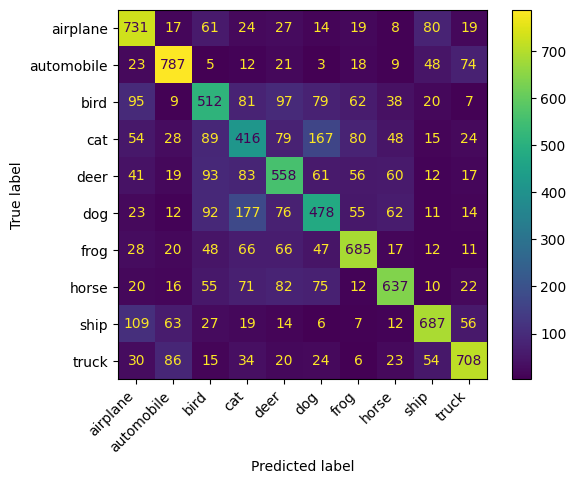

In [31]:
color = 'white'
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
disp.plot()
plt.xticks(rotation=45, ha='right')
plt.show()

In [32]:
print(cm)

[[731  17  61  24  27  14  19   8  80  19]
 [ 23 787   5  12  21   3  18   9  48  74]
 [ 95   9 512  81  97  79  62  38  20   7]
 [ 54  28  89 416  79 167  80  48  15  24]
 [ 41  19  93  83 558  61  56  60  12  17]
 [ 23  12  92 177  76 478  55  62  11  14]
 [ 28  20  48  66  66  47 685  17  12  11]
 [ 20  16  55  71  82  75  12 637  10  22]
 [109  63  27  19  14   6   7  12 687  56]
 [ 30  86  15  34  20  24   6  23  54 708]]


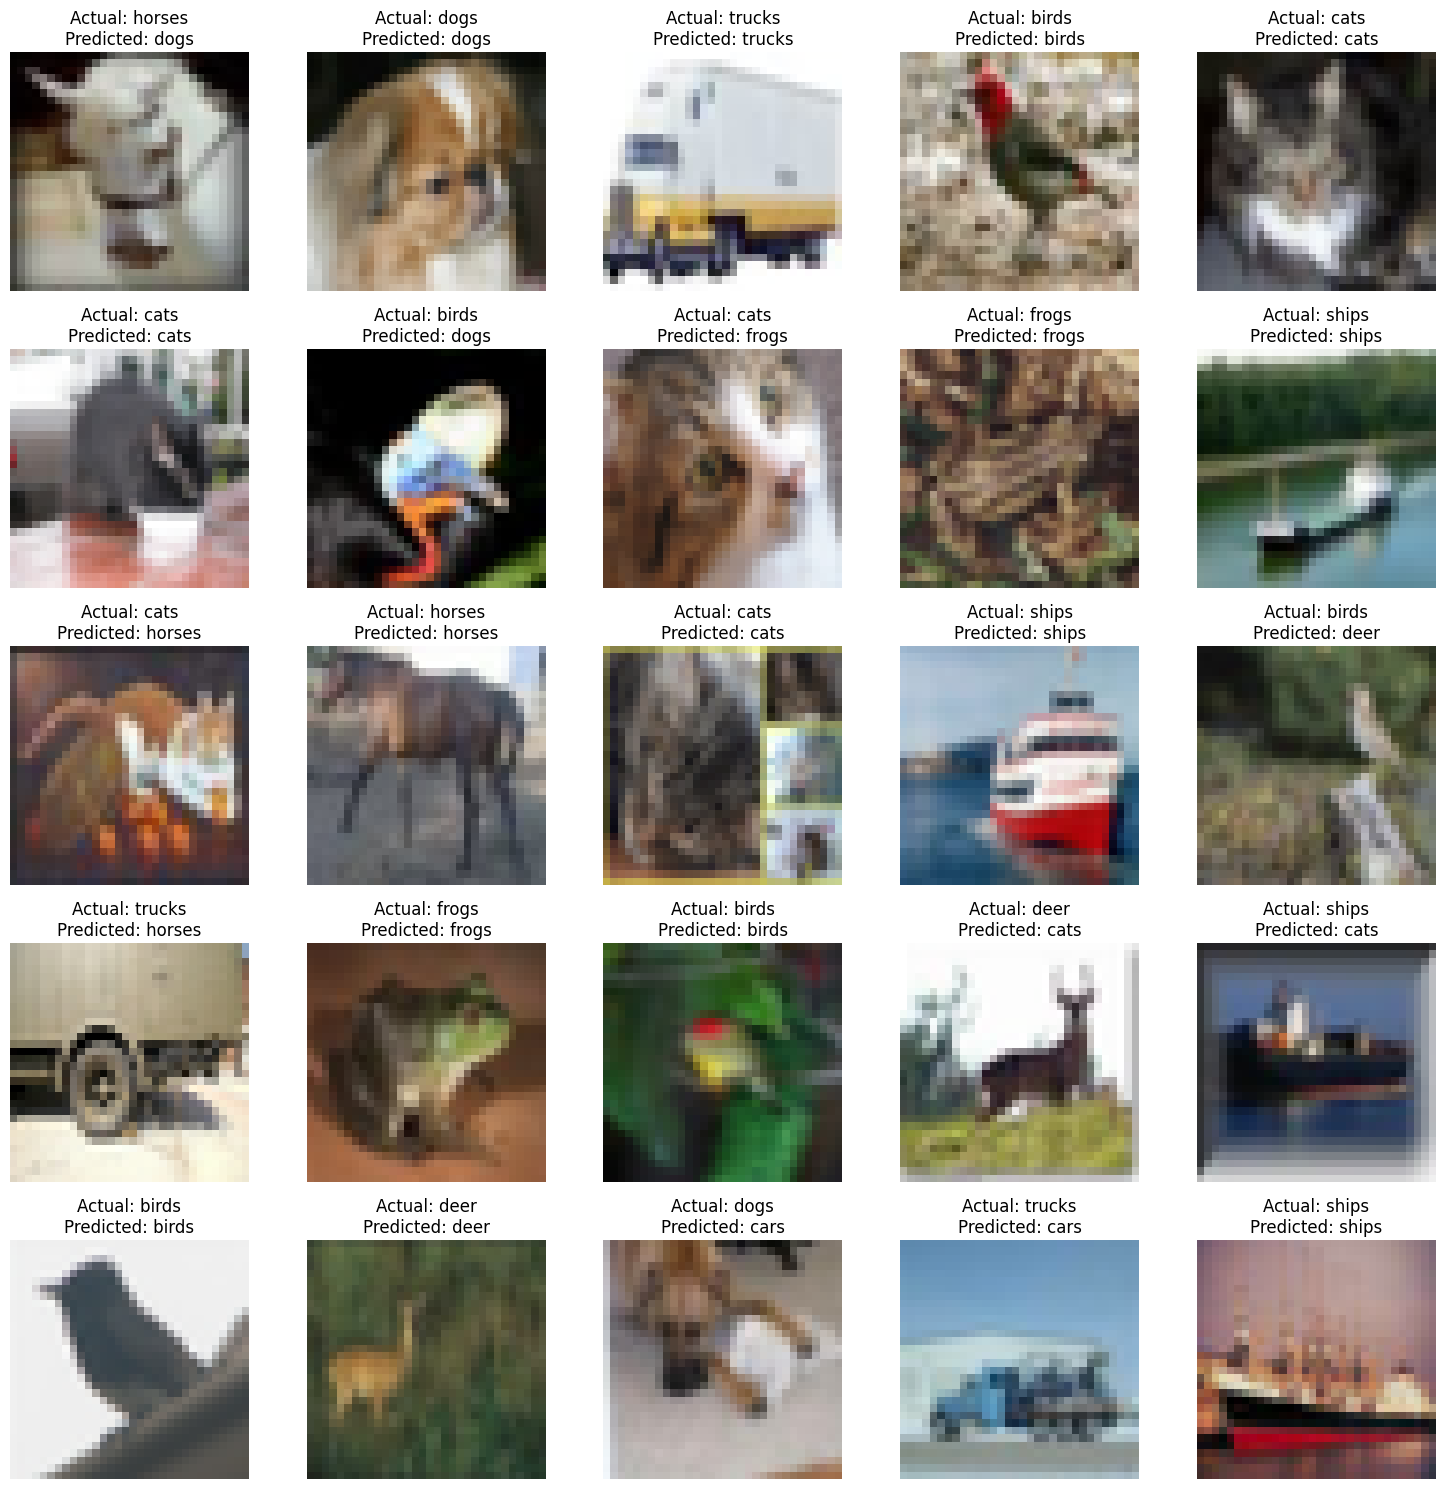

In [18]:
import random

# Define the class labels
class_labels = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']

# Create a 5x5 subplot grid
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

# Loop through 25 random images
for i in range(5):
    for j in range(5):
        # Select a random index
        random_index = random.randint(0, len(x_test) - 1)
        
        # Get the sample image and its true class label
        sample_image = x_test[random_index]
        true_class = y_test[random_index]
        true_class_label = class_labels[true_class]

        # Preprocess the sample image using HOG feature extraction
        gray_sample_image = cv2.cvtColor(sample_image, cv2.COLOR_RGB2GRAY)
        hog_features = hog(gray_sample_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))

        # Reshape HOG features for prediction
        hog_features_reshaped = hog_features.reshape(1, -1)

        # Predict the class label using the trained SVM classifier
        predicted_class = pipe.predict(hog_features_reshaped)[0]

        # Map the predicted class label to the corresponding class name
        predicted_class_label = class_labels[predicted_class]

        # Display the image and the actual/predicted class labels in the subplot
        axes[i, j].imshow(sample_image)
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Actual: {true_class_label}\nPredicted: {predicted_class_label}')

# Adjust layout
plt.tight_layout()
plt.show()


In [13]:
from sklearn.neighbors import KNeighborsClassifier 
pipe1 = Pipeline([('standardscaler', StandardScaler()), 
                 ('pca', PCA(0.8)), 
                 ('knn', KNeighborsClassifier(n_neighbors=5))]) 
pipe1.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.8)),
                ('knn', KNeighborsClassifier())])

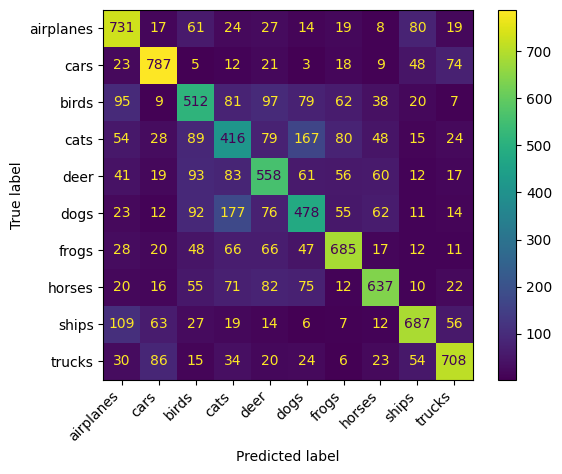

In [14]:
pipe.score(x_test, y_test)
y_pred = pipe.predict(x_test)
color = 'white'
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks'])
disp.plot()
plt.xticks(rotation=45, ha='right')
plt.show()

In [3]:
from sklearn.cluster import KMeans
# Function to extract SIFT descriptors
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    descriptors = []
    for image in tqdm(images):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        kp, des = sift.detectAndCompute(gray, None)
        if des is not None:
            descriptors.extend(des)
    return np.array(descriptors)

# Function to create visual vocabulary using KMeans clustering
def create_visual_vocabulary(features, k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(features)
    return kmeans
# Function to compute BoW representation for images
def compute_bow_representation(images, kmeans):
    bow_descriptors = []
    for image in tqdm(images):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        kp, des = cv2.SIFT_create().detectAndCompute(gray, None)
        if des is not None:
            labels = kmeans.predict(des)
            bow_hist, _ = np.histogram(labels, bins=range(kmeans.n_clusters + 1))
            bow_descriptors.append(bow_hist)
        else:
            bow_descriptors.append(np.zeros(kmeans.n_clusters))
    return np.array(bow_descriptors)


In [4]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Extract SIFT features
sift_features = extract_sift_features(np.concatenate((x_train, x_test), axis=0))

# Create visual vocabulary (BoW)
k = 1000  # Number of clusters
visual_vocabulary = create_visual_vocabulary(sift_features, k)


100%|██████████| 60000/60000 [00:47<00:00, 1254.91it/s]
c:\Users\natha.NSLEGION\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [5]:
# Compute BoW representations for training and test images
x_train_bow = compute_bow_representation(x_train, visual_vocabulary)
x_test_bow = compute_bow_representation(x_test, visual_vocabulary)

100%|██████████| 10000/10000 [00:17<00:00, 584.07it/s]


In [6]:
pipe = Pipeline([('standardscaler', StandardScaler()), ('pca', PCA(0.8)), ('rbfsvc', SVC(kernel='rbf', C=10, cache_size=10000))])
pipe.fit(x_train_bow, y_train)
# Save the trained pipeline
dump(pipe, 'pipe_svm_sift_bow.joblib')

# Load the trained pipeline
pipe = load('pipe_svm_sift_bow.joblib')

c:\Users\natha.NSLEGION\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
# Evaluate the classifier
accuracy = pipe.score(x_test_bow, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.3024


In [ ]:
# Generate and display confusion matrix
y_pred = pipe.predict(x_test_bow)

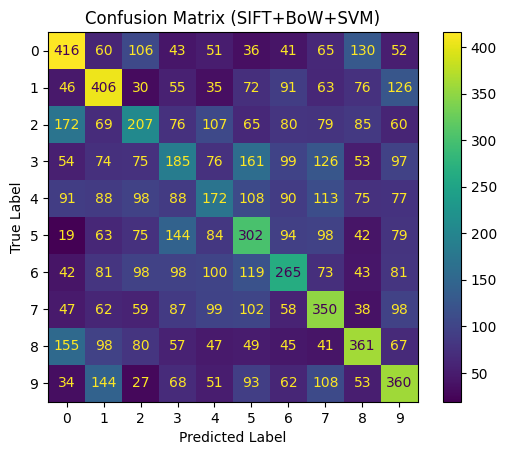

In [13]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (SIFT+BoW+SVM)')
plt.show()

In [11]:
from sklearn.metrics import classification_report

# Calculate precision, recall, F1 score, and support
report = classification_report(y_test, y_pred, target_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Print the report
print(report)

              precision    recall  f1-score   support

    airplane       0.39      0.42      0.40      1000
  automobile       0.35      0.41      0.38      1000
        bird       0.24      0.21      0.22      1000
         cat       0.21      0.18      0.19      1000
        deer       0.21      0.17      0.19      1000
         dog       0.27      0.30      0.29      1000
        frog       0.29      0.27      0.28      1000
       horse       0.31      0.35      0.33      1000
        ship       0.38      0.36      0.37      1000
       truck       0.33      0.36      0.34      1000

    accuracy                           0.30     10000
   macro avg       0.30      0.30      0.30     10000
weighted avg       0.30      0.30      0.30     10000



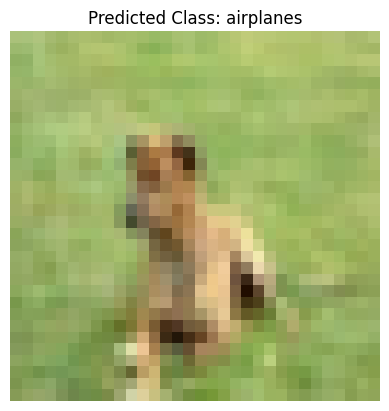

In [43]:
import random

# Select a random image from the dataset
random_index = random.randint(0, len(x_test) - 1)
sample_image = x_test[random_index]

# Extract SIFT descriptors from the sample image
gray_sample_image = cv2.cvtColor(sample_image, cv2.COLOR_RGB2GRAY)
keypoints, descriptors = cv2.SIFT_create().detectAndCompute(gray_sample_image, None)

# Compute BoW representation for the descriptors using the visual vocabulary
labels = visual_vocabulary.predict(descriptors)
bow_hist, _ = np.histogram(labels, bins=range(visual_vocabulary.n_clusters + 1))

# Reshape BoW histogram for prediction
bow_hist_reshaped = bow_hist.reshape(1, -1)

# Predict the class label using the trained kNN classifier
predicted_class = pipe.predict(bow_hist_reshaped)[0]

# Define the class labels
class_labels = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']

# Predict the class label using the trained kNN classifier
predicted_class_label = class_labels[predicted_class]

# Display the original image and the predicted class label
plt.imshow(sample_image)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class_label}')
plt.show()